## NB - binary classification

#### "is_from_NorthAmerica" -> non va molto bene

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [291]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

In [292]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

TRAIN DI PRIMA -> senza features da "countryofOrigin" in poi
'originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe'

In [293]:
pp_class.head(
)

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,countryOfOrigin,countryOfOrigin_freq_enc,countryOfOrigin_NA,countryOfOrigin_AF,countryOfOrigin_AS,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,...,['US'],0.397061,1,0,0,0,0,0,0,29.0
1,Looping,6,1982,1982.0,NaN,0.0,11,1,0,1,...,['XWG'],0.013525,0,0,0,0,0,0,1,NaN
2,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,...,['RU'],0.007959,0,0,0,1,0,0,0,94.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,22,0,56,...,['MX'],0.013636,1,0,0,0,0,0,0,30.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,347,2,47,...,['KR'],0.009184,0,0,1,0,0,0,0,80.0


## Filtro dataset su classi meno rappresentate -> capire se 1,5,6,9 o 7,8,9

In [294]:
 #pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

### Selezione variabile target

In [295]:
y_train = np.array(pp_class['is_from_North America'])  # Il target originale
y_test = np.array(pp_test_class["is_from_North America"])

### preprocessing variabili

In [296]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
##pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

In [297]:
column2drop = ['originalTitle', 'runtimeMinutes']
pp_class.drop(column2drop, axis=1, inplace=True)
##pp_test_class.drop(column2drop, axis=1, inplace=True)

#### endYear da gestire

In [298]:
pp_class= pp_class.drop(["endYear"], axis=1)
##pp_test_class= pp_class.drop(["endYear"], axis=1)

#### Binarizzazione da capire

In [299]:

#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)
pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
pp_class['awardNominationsExcludeWins_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)

pp_test_class['awardWins_bin'] = (pp_test_class['awardWins'] > 0).astype(int)
pp_test_class['totalVideos_bin'] = (pp_test_class['totalVideos'] > 0).astype(int)
pp_test_class['awardNominationsExcludeWins_bin'] = (pp_test_class['awardNominationsExcludeWins'] > 0).astype(int)


In [300]:
#2 discretizzazione per fasce -> decise con 
#pp_class['awardNominationsExcludeWins'].value_counts().sort_index()

In [301]:
# bins_awards = [0, 1, 10, float('inf')]
# labels_awards = [0, 1, 2]  # Mantengo valori numerici per compatibilità con algoritmi
# pp_class['awardWins_bin'] = pd.cut(pp_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)
# ## pp_test_class['awardWins_bin'] = pd.cut(pp_test_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)



# bins_videos = [0, 1, 6, float('inf')]
# labels_videos = [0, 1, 2]
# pp_class['totalVideos_bin'] = pd.cut(pp_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)
# ## pp_test_class['totalVideos_bin'] = pd.cut(pp_test_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)



# bins_nom = [0, 1, 5, float('inf')]
# labels_nom = [0, 1, 2]
# pp_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_class['awardNominationsExcludeWins'], 
#                                                     bins=bins_nom, 
#                                                     labels=labels_nom, 
#                                                     right=False)
# ## pp_test_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_train_class['awardNominationsExcludeWins'], 
# #                                                    bins=bins_nom, 
# #                                                    labels=labels_nom, 
# #                                                    right=False)



# # Assicurati che le nuove colonne siano di tipo numerico
# pp_class['awardWins_bin'] = pp_class['awardWins_bin'].astype(int)
# pp_class['totalVideos_bin'] = pp_class['totalVideos_bin'].astype(int)
# pp_class['awardNominationsExcludeWins_bin'] = pp_class['awardNominationsExcludeWins_bin'].astype(int)

# ## pp_test_class['awardWins_bin'] = pp_test_class['awardWins_bin'].astype(int)
# ## pp_test_class['totalVideos_bin'] = pp_test_class['totalVideos_bin'].astype(int)
# ## pp_test_class['awardNominationsExcludeWins_bin'] = pp_test_class['awardNominationsExcludeWins_bin'].astype(int)


## array di valori per selezione feature classificazione

In [302]:
X_train = pp_class[[
       'rating',
       'startYear',  
       'numVotes', 
       #'totalImages', 
       'totalCredits', 
       'criticReviewsTotal',
       #'canHaveEpisodes', 
       #'isAdult', 
       #'numRegions', 
       'userReviewsTotal', #lasciare
       #'endYear',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       #'fill_runtimeMinutes', 
       #'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       'awardWins_bin',  
       #'totalVideos_bin', 
       'awardNominationsExcludeWins_bin', 
# #AGGIUNTE TRAIN BRUNO
#     'countryOfOrigin', 
       ##'countryOfOrigin_freq_enc', ## -> migliora di troppo
#     'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
#     'fill_runtimeMinutes_Bruno'       
       ]].values

## X_test = pp_test_class[[ ]].values

### Splitting in validation

In [303]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32)

In [304]:
print(X_train2.shape, X_val.shape, X_train.shape,
      #, X_test.shape
      )

(13144, 36) (3287, 36) (16431, 36)


Normalizzazione

In [305]:
X_train2_log = np.log1p(X_train2)
X_val_log= np.log1p(X_val)

## X_train_log = np.log1p(X_train)
## X_test_log = np.log1p(X_test)

In [306]:

standardsc = StandardScaler()

        # # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

## X_train_standardsc = standardsc.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
## X_test_standardsc = standardsc.transform(X_test_log)

In [307]:
# minmax = MinMaxScaler()

        ## Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)

## X_train_minmax = minmax.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)

In [308]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## X_train_tr = X_train_standardsc
## X_test_tr = X_test_standardsc

## NAIVE BAYES

### Gaussian

In [309]:
clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf.fit(X_train2_tr, y_train2)

GaussianNB()

Predicting on validation set

In [310]:
y_pred = clf.predict(X_val_tr)

In [311]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3287
3287


In [312]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1}
{0, 1}


Classification report

In [313]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.6133252205658656

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.86      0.70      1741
           1       0.68      0.34      0.45      1546

    accuracy                           0.61      3287
   macro avg       0.64      0.60      0.58      3287
weighted avg       0.63      0.61      0.58      3287



In [314]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[4.83205334e-01, 5.16794666e-01],
       [9.99112878e-01, 8.87121676e-04],
       [9.81852480e-01, 1.81475203e-02],
       ...,
       [9.98660624e-01, 1.33937636e-03],
       [7.47624598e-01, 2.52375402e-01],
       [9.97595578e-01, 2.40442198e-03]])

overfitting

Performance sul Training set:
Accuracy: 0.6047
F1 Score: 0.5743

Performance sul Validation set:
Accuracy: 0.6133
F1 Score: 0.5843


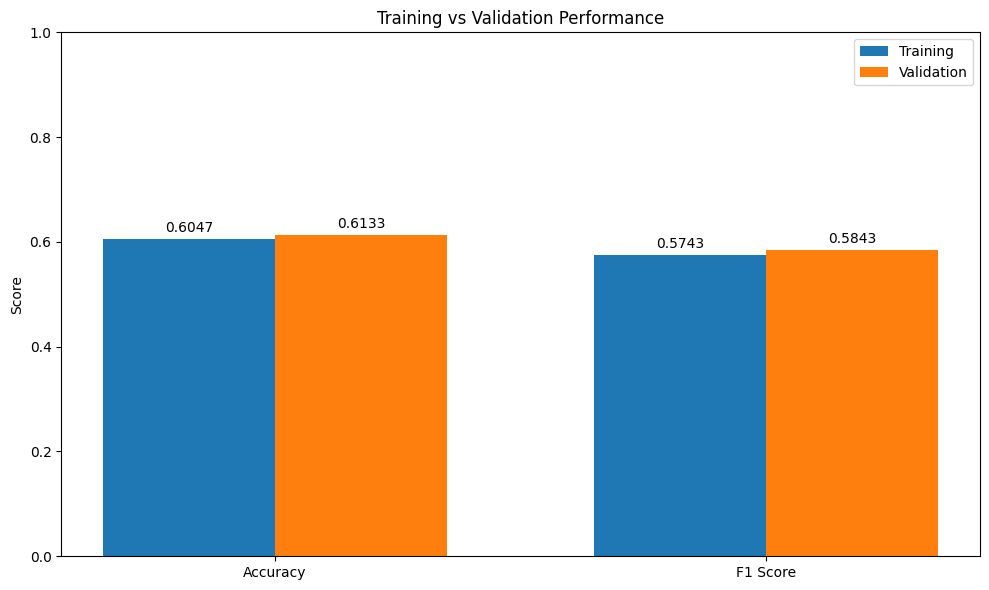

In [315]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [316]:
print("y_val shape:", y_val.shape)
print("y_val dtype:", y_val.dtype)
print("primi elementi di y_val:", y_val[:5])  # Mostra i primi 5 elementi

y_val shape: (3287,)
y_val dtype: int64
primi elementi di y_val: [1 0 0 0 0]


In [317]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

prova 2 roc

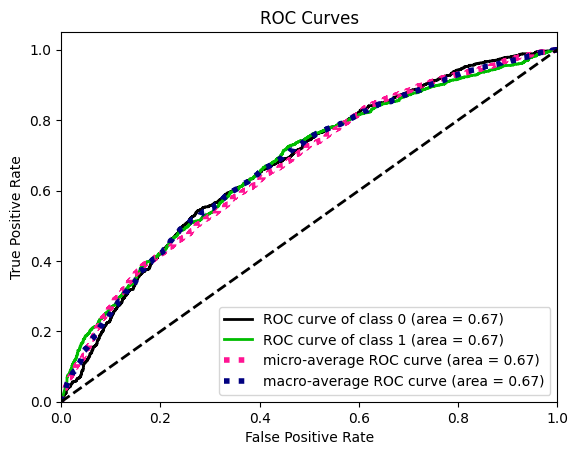

0.6743655970866247


In [318]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

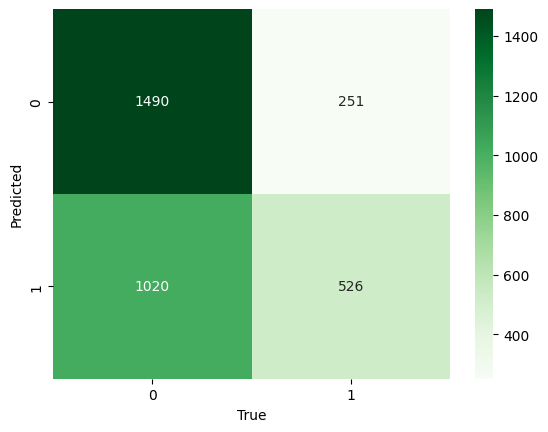

In [319]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Distribuzioni classi nel train2

In [320]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    6834
1    6310
Name: count, dtype: int64


## Proper testing on the test set

In [321]:
#clf = GaussianNB()
## clf = ComplementNB()
#clf.fit(X_train_tr, y_train)
# y_tpred = clf.predict(X_test_tr)
# y_tpred

In [322]:
# # Importazioni necessarie (se non già importate)
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Valutazione sul training set
# y_pred_train = clf.predict(X_train_tr)
# train_accuracy = accuracy_score(y_train, y_pred_train)
# train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# # Valutazione sul test set
# y_pred_test = clf.predict(X_test_tr)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# test_f1 = f1_score(y_test, y_pred_test, average='weighted')
#                         ### gaia ha messo y_tpred

# # Stampa dei risultati
# print(f"Performance sul Training set:")
# print(f"Accuracy: {train_accuracy:.4f}")
# print(f"F1 Score: {train_f1:.4f}")
# print("\nPerformance sul test set:")
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"F1 Score: {test_f1:.4f}")

# # Visualizzazione grafica del confronto
# metrics = ['Accuracy', 'F1 Score']
# train_scores = [train_accuracy, train_f1]
# test_scores = [test_accuracy, test_f1]

# x = np.arange(len(metrics))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
# rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

# ax.set_ylabel('Score')
# ax.set_title('Training vs Validation Performance')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()
# ax.set_ylim(0, 1)

# # Aggiungi i valori sopra le barre
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.4f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()

In [323]:
# print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

In [324]:
# classes_unique = np.unique(y_test)
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
#             xticklabels=classes_unique, 
#             yticklabels=classes_unique)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.tight_layout()
# plt.show()

### devo cambiare qlcs? Dummy classifier

In [325]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Create dummy classifier (most frequent class strategy)
# dummy = DummyClassifier(strategy="most_frequent")
# dummy.fit(X_train_tra, y_train)

# # Predict and evaluate
# y_pred = dummy.predict(X_test_tr)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

## "lowEngagement"

In [326]:
pp_class["lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test["lowEngagement"] = (pp_test["numVotes"]<100).astype(int)

In [327]:
x = sum(pp_class["lowEngagement"] == 1)
x

11289

Selezione variabile target

In [328]:
y_train = np.array(pp_class["lowEngagement"]) #target originale
#y_test = np.array(pp_train["lowEngagement"])

Selezione attributi per classificazione

In [329]:
X_train = pp_class[[
       'rating',
       ## 'startYear',  
       #'numVotes', 
       ##'totalImages', 
       'totalCredits', 
       'criticReviewsTotal',
       ##'canHaveEpisodes', 
       ##'isAdult', 
       'numRegions', 
       'userReviewsTotal', # lasciare
       #'endYear',
       #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       'fill_runtimeMinutes',  #lasciare
       'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       'awardWins_bin',  
       ##'totalVideos_bin', 
       'awardNominationsExcludeWins_bin', 
# #AGGIUNTE TRAIN BRUNO
#     'countryOfOrigin', 
       #'countryOfOrigin_freq_enc',
       #'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
#     'fill_runtimeMinutes_Bruno'       
       ]].values

## X_test = pp_test_class[[ ]].values

Splitting in train-validation

In [330]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32)

normalizzazione

In [331]:
X_train2_log = np.log1p(X_train2)
X_val_log= np.log1p(X_val)

## X_train_log = np.log1p(X_train)
## X_test_log = np.log1p(X_test)

In [332]:

standardsc = StandardScaler()

        # # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

## X_train_standardsc = standardsc.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
## X_test_standardsc = standardsc.transform(X_test_log)

In [333]:
# minmax = MinMaxScaler()

        ## Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)

## X_train_minmax = minmax.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)

In [334]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## X_train_tr = X_train_standardsc
## X_test_tr = X_test_standardsc

## Naive Bayes

In [335]:
clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) #-> non va perchè ci sono valori negativi
clf.fit(X_train2_tr, y_train2)

GaussianNB()

Prediction on validation set

In [336]:
y_pred = clf.predict(X_val_tr)

In [337]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3287
3287


In [338]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8220261636750836

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      1074
           1       0.84      0.91      0.87      2213

    accuracy                           0.82      3287
   macro avg       0.81      0.78      0.79      3287
weighted avg       0.82      0.82      0.82      3287



In [339]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[1.00000000e+00, 1.98195904e-25],
       [2.82658726e-02, 9.71734127e-01],
       [2.69675512e-01, 7.30324488e-01],
       ...,
       [7.61722016e-03, 9.92382780e-01],
       [1.74342357e-02, 9.82565764e-01],
       [1.60282338e-01, 8.39717662e-01]])

Performance sul Training set:
Accuracy: 0.8257
F1 Score: 0.8239

Performance sul Validation set:
Accuracy: 0.8220
F1 Score: 0.8177


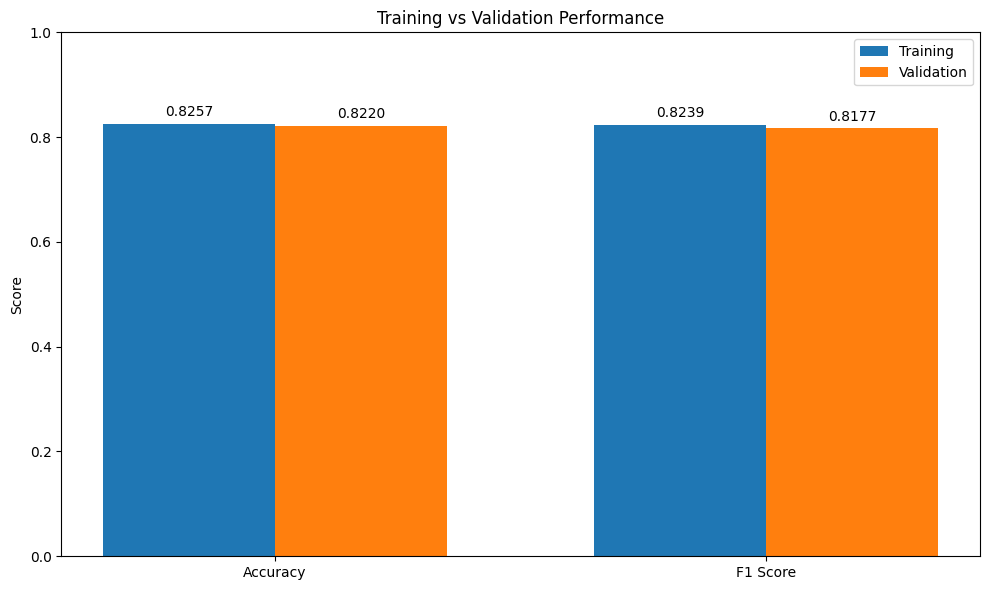

In [340]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [341]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

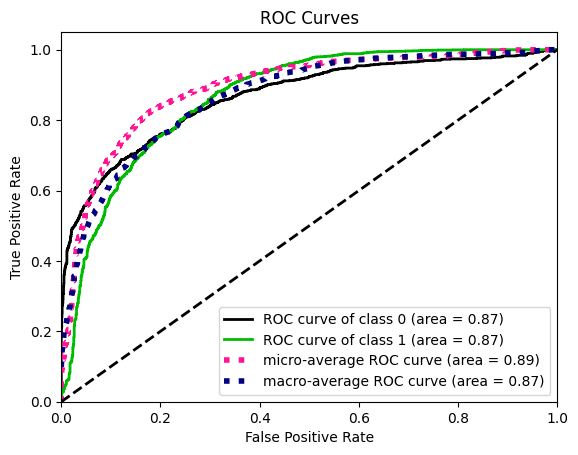

0.8663627237392721


In [342]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

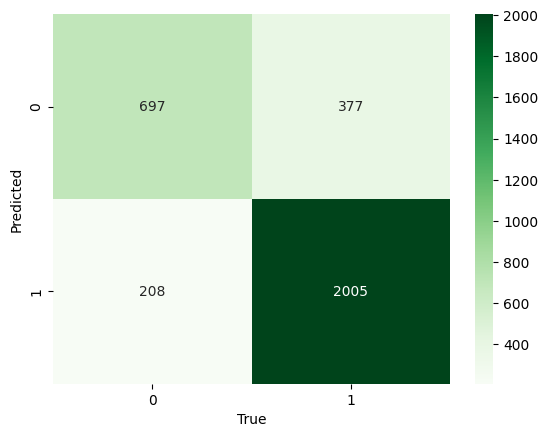

In [343]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

### Prediction on the test set

In [344]:
#clf = GaussianNB()
## clf = ComplementNB()
#clf.fit(X_train_tr, y_train)
# y_tpred = clf.predict(X_test_tr)
# y_tpred

In [345]:
# # Importazioni necessarie (se non già importate)
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Valutazione sul training set
# y_pred_train = clf.predict(X_train_tr)
# train_accuracy = accuracy_score(y_train, y_pred_train)
# train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# # Valutazione sul test set
# y_pred_test = clf.predict(X_test_tr)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# test_f1 = f1_score(y_test, y_pred_test, average='weighted')
#                         ### gaia ha messo y_tpred

# # Stampa dei risultati
# print(f"Performance sul Training set:")
# print(f"Accuracy: {train_accuracy:.4f}")
# print(f"F1 Score: {train_f1:.4f}")
# print("\nPerformance sul test set:")
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"F1 Score: {test_f1:.4f}")

# # Visualizzazione grafica del confronto
# metrics = ['Accuracy', 'F1 Score']
# train_scores = [train_accuracy, train_f1]
# test_scores = [test_accuracy, test_f1]

# x = np.arange(len(metrics))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
# rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

# ax.set_ylabel('Score')
# ax.set_title('Training vs Validation Performance')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()
# ax.set_ylim(0, 1)

# # Aggiungi i valori sopra le barre
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.4f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()

In [346]:
# print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

In [347]:
# classes_unique = np.unique(y_test)
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
#             xticklabels=classes_unique, 
#             yticklabels=classes_unique)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.tight_layout()
# plt.show()

## Dummy classifier -> cambia qlcs?

In [348]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Create dummy classifier (most frequent class strategy)
# dummy = DummyClassifier(strategy="most_frequent")
# dummy.fit(X_train_tra, y_train)

# # Predict and evaluate
# y_pred = dummy.predict(X_test_tr)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))